In [3]:
import os
import zipfile

In [2]:
local_zip = './base_act/base.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('./base_act')
zip_ref.close()

In [4]:
os.listdir('./base_act')

['midblock_left',
 'topblock_right',
 'topblock_left',
 'bodyhit_right',
 'base.zip',
 'midblock_right',
 'bodyhit_left']

In [5]:
# 기본 경로
base_dir = './k_data'

In [6]:
import matplotlib.pylab as plt

import tensorflow as tf

In [7]:
import tensorflow.compat.v1 as tf
import tensorflow_hub as hub

In [8]:
from tensorflow.keras import layers

In [9]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" 

In [10]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

2022-03-16 05:35:26.833503: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-16 05:35:26.834689: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-16 05:35:26.860866: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 05:35:26.862151: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: Tesla V100S-PCIE-32GB computeCapability: 7.0
coreClock: 1.597GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 1.03TiB/s
2022-03-16 05:35:26.862171: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-16 05:35:26.863749: I tensorflow/stream_executor/platform/defau

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [11]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


65536/61306 [================================] - 0s 2us/step


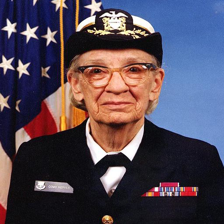

In [17]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [18]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [19]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

2022-03-16 06:28:09.883690: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-03-16 06:28:09.884210: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2992965000 Hz
2022-03-16 06:28:10.274433: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-03-16 06:28:11.659769: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


(1, 1001)

In [20]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

In [21]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 1us/step


In [168]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory('./base_act', target_size=IMAGE_SHAPE)

TypeError: flow_from_directory() got an unexpected keyword argument 'validation_split'

In [107]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break


Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 6)


In [108]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [94]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"

In [109]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

In [111]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [112]:
feature_extractor_layer.trainable = False

In [113]:
with tf.device("/gpu:0"):
    model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(image_data.num_classes, activation='softmax')
    ])

In [114]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_5 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 7686      
Total params: 2,265,670
Trainable params: 7,686
Non-trainable params: 2,257,984
_________________________________________________________________


In [115]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [116]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [117]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-03-16 08:02:48.003248: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2727665923467517994,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 31589217152
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2532707834600966404
 physical_device_desc: "device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:03:00.0, compute capability: 7.0"]

2022-03-16 08:02:48.003566: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: Tesla V100S-PCIE-32GB computeCapability: 7.0
coreClock: 1.597GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 1.03TiB/s
2022-03-16 08:02:48.003599: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-16 08:02:48.003632: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-03-16 08:02:48.003640: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-03-16 08:02:48.003647: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
2022-03-16 08:02:48.003654: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcura

In [103]:
print(image_data.samples/image_data.batch_size)

48.4453125


In [119]:
import time, random, datetime
import numpy as np
import tensorflow as tf

class DataLoader(tf.keras.utils.Sequence):
    def __len__(self):
        return 10
    def __getitem__(self, i):
        time.sleep(random.randint(1,2))
        #you could add a print here to see that it's out of order
        return i

In [120]:
def test(workers):
    enq = tf.keras.utils.OrderedEnqueuer(DataLoader())
    enq.start(workers = workers)
    gen = enq.get()

    results = []
    start = datetime.datetime.now()
    for i in range(30):
        results.append(next(gen))
    enq.stop()
    print('test with', workers, 'workers took', datetime.datetime.now() - start)
    print("results:", results)

In [126]:
test(12)

test with 12 workers took 0:00:06.116179
results: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [127]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

enq = tf.keras.utils.OrderedEnqueuer(DataLoader())
enq.start(workers = 48)
gen = enq.get()
history = model.fit_generator(image_data, epochs=30,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])
enq.stop()

Epoch 1/30
194/194 [==============================] - 772s 4s/step - loss: 0.5252 - acc: 0.8438
Epoch 2/30
194/194 [==============================] - 774s 4s/step - loss: 0.3576 - acc: 0.9375
Epoch 3/30
194/194 [==============================] - 773s 4s/step - loss: 0.2480 - acc: 0.9375
Epoch 4/30
194/194 [==============================] - 770s 4s/step - loss: 0.1055 - acc: 1.0000
Epoch 5/30
194/194 [==============================] - 785s 4s/step - loss: 0.2107 - acc: 0.9688
Epoch 6/30
194/194 [==============================] - 772s 4s/step - loss: 0.1160 - acc: 1.0000
Epoch 7/30
194/194 [==============================] - 768s 4s/step - loss: 0.2699 - acc: 0.9688
Epoch 8/30
194/194 [==============================] - 768s 4s/step - loss: 0.0835 - acc: 1.0000
Epoch 9/30
194/194 [==============================] - 770s 4s/step - loss: 0.1710 - acc: 0.9688
Epoch 10/30
194/194 [==============================] - 767s 4s/step - loss: 0.1564 - acc: 1.0000
Epoch 11/30
194/194 [==================

In [179]:
import time
t = time.time()

export_path = "{}".format(int(t))
model.save(export_path, save_format='tf')

export_path

INFO:tensorflow:Assets written to: 1647449498/assets


INFO:tensorflow:Assets written to: 1647449498/assets


'1647449498'

In [180]:
reloaded = tf.keras.models.load_model(export_path)

In [181]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [182]:
reloaded.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_5 (KerasLayer)   (None, 1280)              1280      
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 7686      
Total params: 8,966
Trainable params: 7,686
Non-trainable params: 1,280
_________________________________________________________________


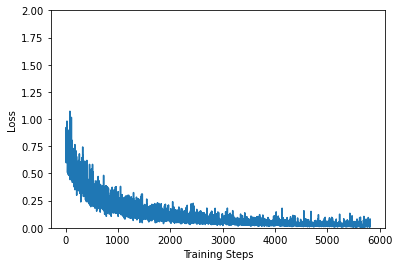

In [128]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

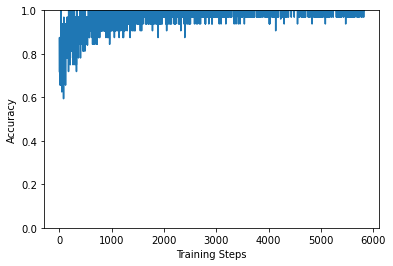

In [129]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [130]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Bodyhit_Left', 'Bodyhit_Right', 'Midblock_Left', 'Midblock_Right',
       'Topblock_Left', 'Topblock_Right'], dtype='<U14')

In [171]:
image_data = image_generator.flow_from_directory('./base_act', target_size=IMAGE_SHAPE)

Found 6201 images belonging to 6 classes.


In [ ]:
for image_batch, label_batch in image_datass:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break


In [155]:
np.argmax(result[0], axis=-1)

[[[[0.4901961  0.47450984 0.427451  ]
   [0.45882356 0.43529415 0.38823533]
   [0.45882356 0.45098042 0.3921569 ]
   ...
   [0.43137258 0.28627452 0.10980393]
   [0.45098042 0.29803923 0.13725491]
   [0.43529415 0.2627451  0.10980393]]

  [[0.47058827 0.44705886 0.3921569 ]
   [0.4666667  0.4431373  0.38823533]
   [0.45882356 0.45098042 0.3921569 ]
   ...
   [0.41960788 0.27450982 0.10980393]
   [0.43137258 0.28627452 0.12156864]
   [0.44705886 0.27450982 0.12941177]]

  [[0.47450984 0.4431373  0.3921569 ]
   [0.47450984 0.45098042 0.39607847]
   [0.46274513 0.44705886 0.40000004]
   ...
   [0.45098042 0.30588236 0.14117648]
   [0.40784317 0.25882354 0.10588236]
   [0.41176474 0.24705884 0.09803922]]

  ...

  [[0.5254902  0.5568628  0.5647059 ]
   [0.49803925 0.52156866 0.52156866]
   [0.49803925 0.5294118  0.5372549 ]
   ...
   [0.48627454 0.31764707 0.14901961]
   [0.5137255  0.34117648 0.15686275]
   [0.4666667  0.29411766 0.11764707]]

  [[0.5294118  0.56078434 0.5686275 ]
   [0.5

In [131]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [132]:
label_id = np.argmax(label_batch, axis=-1)

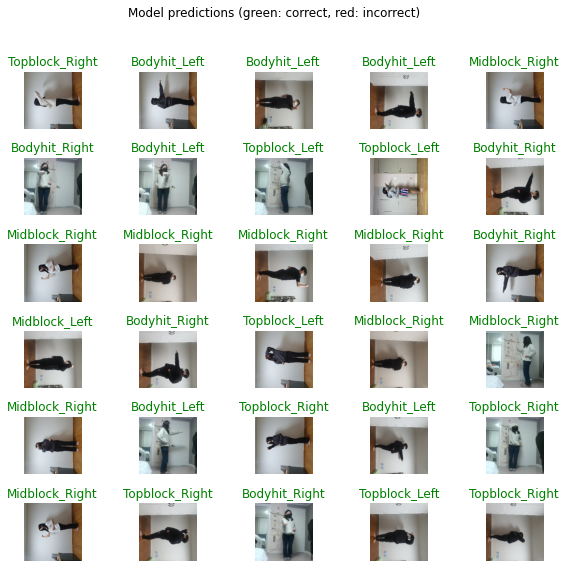

In [133]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [151]:
test = os.listdir('./test')

In [160]:
test

['KakaoTalk_20220317_004026240_02.jpg',
 'KakaoTalk_20220317_004026240.jpg',
 'KakaoTalk_20220317_004026240_13.jpg',
 'KakaoTalk_20220317_004026240_06.jpg',
 'KakaoTalk_20220317_004026240_12.jpg',
 'KakaoTalk_20220317_004026240_10.jpg',
 'KakaoTalk_20220317_004026240_08.jpg',
 'KakaoTalk_20220317_004026240_16.jpg',
 'KakaoTalk_20220317_004026240_11.jpg',
 'KakaoTalk_20220317_004026240_04.jpg',
 'KakaoTalk_20220317_004026240_01.jpg',
 'KakaoTalk_20220317_004026240_14.jpg',
 'KakaoTalk_20220317_004026240_05.jpg',
 'KakaoTalk_20220317_004026240_15.jpg',
 'KakaoTalk_20220317_004026240_09.jpg',
 'KakaoTalk_20220317_004026240_17.jpg',
 'KakaoTalk_20220317_004026240_03.jpg',
 'KakaoTalk_20220317_004026240_07.jpg']

In [141]:
%conda install keras

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.2
  latest version: 4.12.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/team1/anaconda3/envs/tmp

  added / updated specs:
    - keras


The following NEW packages will be INSTALLED:

  keras              pkgs/main/noarch::keras-2.4.3-hd3eb1b0_0
  keras-base         pkgs/main/noarch::keras-base-2.4.3-pyhd3eb1b0_0
  pyyaml             pkgs/main/linux-64::pyyaml-6.0-py39h7f8727e_1
  yaml               pkgs/main/linux-64::yaml-0.2.5-h7b6447c_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


In [142]:
import numpy as np
from keras.preprocessing import image

In [162]:
img=image.load_img('./test/'+test[1], target_size=(224,224))
x=image.img_to_array(img)
x=np.expand_dims(x, axis=0)
images = np.vstack([x])


In [163]:
classes = model.predict(images)

In [164]:
print(max(classes[0]))

0.48642915


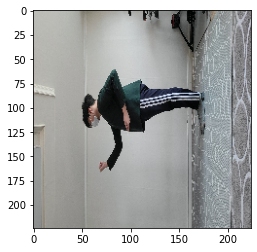

In [165]:
plt.imshow(img)

In [166]:
predicted_label_batch[np.argmax(classes[0], axis=-1)]
# label_id[np.argmax(classes[0], axis=-1)]

'Bodyhit_Left'

In [ ]:

for n in range(len(test)):
    img=image.load_img('./test/'+test[1], target_size=(224,224))
    x=image.img_to_array(img)
    x=np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict(images)